In [1]:
# Import packages.
import queue, random, threading, math, time, pickle, psutil
import Adjustable_Snake as snake    # Snake game.
import tensorflow as tf             # Tensorflow.
import numpy as np                  # I chose NumPy instead of Pandas because it uses less RAM.
import tkinter as tkinter           # Required to control the game.
import matplotlib.pyplot as plt     # Plotting statistics.

# This code allows for the GPU to be utilized properly.
tf.autograph.set_verbosity(0)
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    physical_devices

print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Save directory, includes model and replay memory.
save_path = "./save"


# Hyperparameters below control the training of the agent.

stack_size = 2  # Phi; amount of frames the agent sees e.g. stack_size 4 means the agent sees the 
                # last 4 frames.

game_size = 32  # The dimensions of the game (it is square).


epsilon_threshold = 256     # The epsilon slope plateaus when the agent averages this score over.
                            # all episodes e.g. epsilon stops changing when the agent averages 
                            # 100 points if epsilon_threshold = 100.

learning_threshold = 25000  # The agent begins learning and obeying the epsilon-greedy policy after 
                            # playing through this many episodes.

start_epsilon = 0.5         # The epsilon slope begins at this float. 


discount = 0.99         # Discount factor. A higher discount factor determines how much the agent
                        # should care about prioritizing the future vs. the present.

learning_rate = 0.01   # AKA step size.

c = 1000                # The target Q-network (Q-hat) is reset to the behaviour Q-net after this
                        # many frames.


memory_size = 50000 # The size of the replay memory.

batch_size = 64     # The mini-batch size used for a gradient descent step.

In [3]:
def make_model():
    '''Creates a tf.keras.Sequential model with numerous hidden layers.'''
    q = tf.keras.Sequential()

    input_size = (game_size, game_size, stack_size, 3)  # The input tensor to the model.

    # Convolution layers.
    q.add(tf.keras.layers.Conv3D(game_size, (3, 3, 1),
                                activation="linear", input_shape=input_size))
    q.add(tf.keras.layers.MaxPooling3D((2, 2, 1)))

    q.add(tf.keras.layers.Conv3D(game_size * 2, (3, 3, 1), activation="linear"))
    q.add(tf.keras.layers.MaxPooling3D((2, 2, 1)))

    q.add(tf.keras.layers.Conv3D(game_size * 2, (3, 3, 1), activation="linear"))
    q.add(tf.keras.layers.MaxPooling3D((2, 2, 1)))

    # Convert to dense.
    q.add(tf.keras.layers.Flatten())

    # Fully-connected layers.
    q.add(tf.keras.layers.Dense(64, activation="linear"))
    q.add(tf.keras.layers.Dense(10, activation="linear"))
    q.add(tf.keras.layers.Dense(5)) # 5 outputs for 5 different actions.

    q.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), loss="mse")
    return q

In [4]:
try:
    # Try to load a saved model.
    q1 = tf.keras.models.load_model(save_path + "/model1")
    target_q = tf.keras.models.load_model(save_path + "/target_q")

    print("Loaded models")
except Exception as e:
    # Create a model if no save exists.
    print(e)
    q1 = make_model()
    target_q = make_model()
    print("Created model")

q1.summary()
target_q.summary()

SavedModel file does not exist at: ./save/model1/{saved_model.pbtxt|saved_model.pb}
Created model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 30, 2, 32)     896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 15, 2, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 13, 13, 2, 64)     18496     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 6, 2, 64)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 4, 2, 64)       36928     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 2, 2, 64)       0         
________________________

In [5]:
try:
    # Try to load replay memory and statistics.
    with open(save_path + "/update_index.dat", "rb") as openfile:
        update_index = int(pickle.load(openfile))
    with open(save_path + "/filled_memory.dat", "rb") as openfile:
        filled_memory = int(pickle.load(openfile))
    with open(save_path + "/reset_steps.dat", "rb") as openfile:
        reset_steps = int(pickle.load(openfile))

    # Replay memory isn't stored using Pickle because it uses too much RAM.
    states_memory = np.load(save_path + "/states_memory.npy")
    action_memory = np.load(save_path + "/action_memory.npy")
    reward_memory = np.load(save_path + "/reward_memory.npy")
    transitions_memory = np.load(save_path + "/transitions_memory.npy")

    # Statistics.
    with open(save_path + "/scores.dat", "rb") as openfile:
        scores = pickle.load(openfile)

    print("Loaded replay memory")
except Exception as e:
    # Create the replay memory if non-existent.
    print(e)
    update_index = 0    # Which index of the replay memory to update.
    filled_memory = 0   # The amount of experiences in the memory.
    reset_steps = 0     # The amount of frames that have passed since the last target_q reset.s

    # Replay Memory.
    states_memory = np.ndarray((memory_size, game_size, game_size, stack_size, 3))
    action_memory = np.ndarray((memory_size))
    reward_memory = np.ndarray((memory_size))
    transitions_memory = np.ndarray((memory_size, game_size, game_size, stack_size, 3))

    # Stats.
    scores = [0]
    
    print("Created replay memory")

[Errno 2] No such file or directory: './save/update_index.dat'
Created replay memory


In [6]:
class agent:
    '''This creates an agent that plays and learns snake. All of the functions
       used for training are contained in this class.'''

    # The possible actions that the agent can take each frame.
    directions = ["UP", "DOWN", "LEFT", "RIGHT", "NONE"]

    def __init__(self, game):
        '''Sets the game window for the agent to control, and initializes the frame stack (phi).'''
        self.game = game
        self.phi = queue.deque()

    def update_memory(self, states, action, reward, transitions):
        '''Creates a new experience in the replay memory. Each experience is stored between 4
           seperate NumPy arrays, at the same index.

           Function Parameters:
           states= the state/frame stack for the experience
           action= the action taken
           reward= the reward received for taking said action in state
           transitions= the frame stack of the frame AFTER taking said action'''

        global update_index, filled_memory
        # Start replacing experiences in the memory from the beginning again.
        if update_index >= memory_size:
            update_index = 0

        # Insert the experience into replay memory.
        states_memory[update_index] = states
        action_memory[update_index] = action
        reward_memory[update_index] = reward
        transitions_memory[update_index] = transitions

        update_index += 1
        # Keep track of how much of the memory has been filled.
        if filled_memory < memory_size:
            filled_memory += 1

    def stack(self, frames):
        '''Formats a frame stack (phi) to be inputtable to the model.
           Function Parameters:
           frames= the frame stack to convert to a single input tensor'''

        # This code is for when I need input to an RGB convolutional model with Conv3D.
        # 
        # fstack = np.stack(frames, axis=2)

        # This code is for when I need input to a black/white convolutional model with Conv2D.
        # 
        # fstack = frames[0]
        # for x in range(1, len(frames)):
        #     frame = np.expand_dims(frames[x], axis=2)
        #     print(fstack.shape)
        #     print(frame.shape)
        #     # frame = frames[x]
        #     fstack = np.stack((fstack, frame), axis=2)
            
        return fstack

    def epsilon_action(self):
        '''The epsilon-greedy policy decides whether the agent will
           choose the action it thinks is best, or choose a random
           action. Currently, there is an epsilon slope, where the
           agent will take less random actions the better it performs.'''

        stack = np.expand_dims(self.stack(self.phi), axis=0)

        if random.uniform(0, 1) <= ((-sum(scores) / len(scores) / epsilon_threshold) + 1) * start_epsilon:
            prediction = [["n/a", "n/a", "n/a", "n/a", "n/a"]]

            action = self.directions[random.randint(0, 4)]
        else:
            prediction = q1.predict(stack)

            maxq = np.argmax(prediction)
            action = self.directions[maxq]
        return action, prediction

    def step(self):
        if len(self.phi) == 0:
            for x in range(stack_size):
                self.phi.append(self.game.get_state())

        action, values = self.epsilon_action()
        state_reward = self.game.step(action, values)

        phi_last = list(self.phi)
        self.phi.append(state_reward[0])

        if len(self.phi) > stack_size:
            phi_last = self.stack(phi_last)
            self.phi.popleft()
            phi_current = self.stack(self.phi)

            self.update_memory(phi_last, self.directions.index(action), state_reward[1], phi_current)

    def get_batch_indices(self, memory):
        indices = []
        for x in range(batch_size):
            indices.append(random.randint(0, filled_memory - 1))

        return indices

    def losses(self):
        yj_tensor = np.ndarray((batch_size))

        created_batches = False

        indices = self.get_batch_indices(states_memory)
        states = states_memory[indices]
        action = action_memory[indices]
        reward = reward_memory[indices]
        transitions = transitions_memory[indices]

        q_phi_next = target_q.predict(transitions)

        # Calculate expected values yj
        for t in range(batch_size):
            if reward[t] == -1:
                yj = reward[t]
            else:
                yj = reward[t] + (discount * np.amax(q_phi_next[t]))
                yj_tensor[t] = yj

        return states, yj_tensor
    def learn(self):
        global reset_steps, c

        if filled_memory > learning_threshold:
            states, expected_data = self.losses()

            q1.train_on_batch(states, expected_data)

            after1 = q1.predict(np.expand_dims(self.stack(self.phi), axis=0))
            if math.isnan(after1[0][0]):
                print("NaN")
            if math.isinf(after1[0][0]):
                print("inf")

            reset_steps += 1
            if reset_steps >= c:
                reset_steps = 0
                target_q.set_weights(q1.get_weights())

In [7]:
def plot():
    print("SCORE v. EPISODE")
    plt.plot(scores)
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.show()
    print("==============================")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


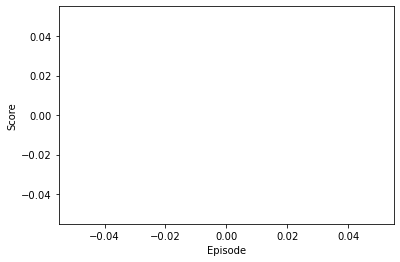

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


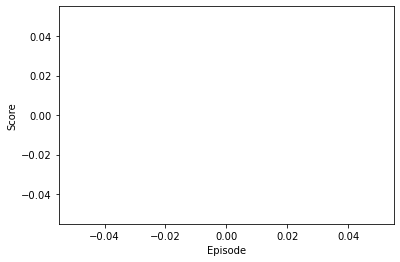

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


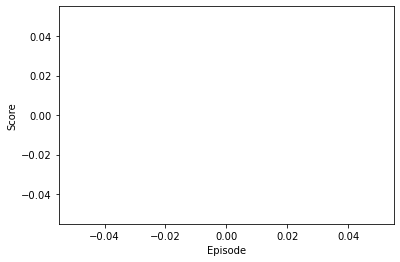

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


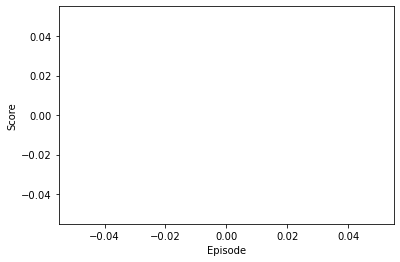

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


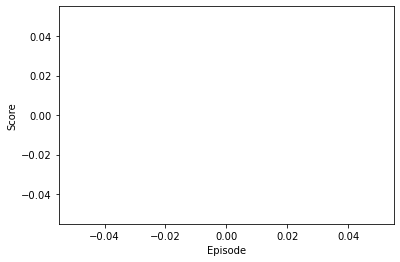

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


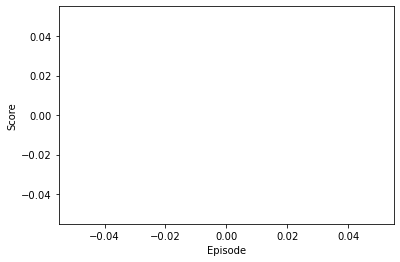

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


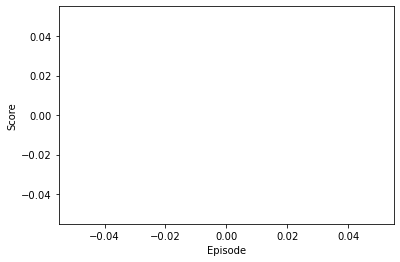

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


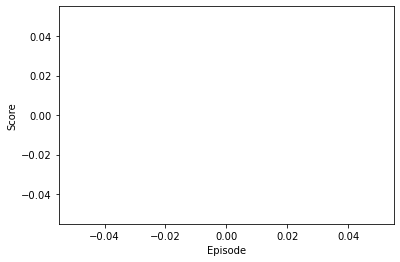

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


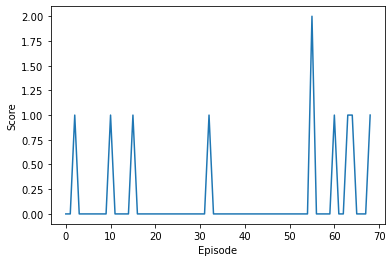

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


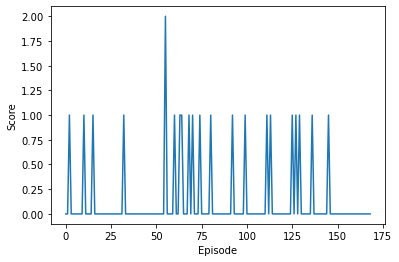

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/target_q\assets
SCORE v. EPISODE


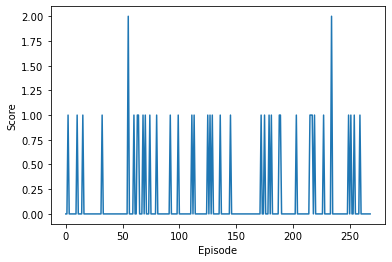

In [8]:
game = snake.game()
x = 0

while True:
    dqn = agent(game)

    game.start(dqn)

    if x % 100 == 0:
        q1.save(save_path + "/model1", overwrite=True, include_optimizer=True)
        q1.save(save_path + "/target_q", overwrite=True, include_optimizer=True)

    if x % 100 == 0:
        with open(save_path + "/update_index.dat", "wb") as openfile:
            pickle.dump(update_index, openfile)
        with open(save_path + "/reset_steps.dat", "wb") as openfile:
            pickle.dump(reset_steps, openfile)
        with open(save_path + "/filled_memory.dat", "wb") as openfile:
            pickle.dump(filled_memory, openfile)

        np.save(save_path + "/states_memory", states_memory)
        np.save(save_path + "/action_memory", action_memory)
        np.save(save_path + "/reward_memory", reward_memory)
        np.save(save_path + "/transitions_memory", transitions_memory)

        # Graphs
        with open(save_path + "/scores.dat", "wb") as openfile:
            pickle.dump(scores, openfile)

        plot()
    x += 1

    # print("Finished episode " + str(x) + ", agent scored " + str(game.score) + " points.")
    if filled_memory > learning_threshold:
        scores.append(game.score)